# 11章 学習済みモデルの利用

In [ ]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [ ]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [ ]:
# GPUチェック

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 共通関数の読み込み

In [ ]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Feb 24 17:49 sample_data


In [ ]:
!rm -rf pythonlibs

In [ ]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 32 (delta 13), reused 23 (delta 7), pack-reused 0
Unpacking objects: 100% (32/32), done.
Common Library for PyTorch
Author: M. Akaishi


## 11.4 nn.AdaptiveAvgPool2d関数

In [ ]:
# nn.AdaptiveAvgPool2dの定義
p = nn.AdaptiveAvgPool2d((1,1))
print(p)

# 線形関数の定義
l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [ ]:
# 学習済みモデルのシミュレーション
inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0],-1)
m3 = l1(m2)

# shape確認
print(m1.shape)
print(m2.shape)
print(m3.shape)

torch.Size([10, 32, 1, 1])
torch.Size([10, 32])
torch.Size([10, 10])


## 11.5 データ準備

In [ ]:
# 分類先クラス名の定義

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(classes)

In [ ]:
# transformの定義

# 学習データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.Resize(128),
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証データ用 : 正規化のみ実施
transform = transforms.Compose([
  transforms.Resize(128),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# データ取得用関数 DataSet

train_set = datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True,
    transform=transform_train)

# 検証データの取得
test_set = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# ミニバッチのサイズ指定
batch_size = 50

# データローダー

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False) 

## 11.6 ResNet18の読み込み

### モデルの読み込み

In [ ]:
#  必要ライブラリのロード
from torchvision import models

# 学習済みモデルのロード
# pretraind = True で重みも一緒に読み込む
net = models.resnet18(pretrained = True)

### モデル構造の確認

In [ ]:
# ネットワークの概要表示

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# モデルのサマリー表示
net = net.to(device)
summary(net,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


最終レイヤー関数の変数名は``fc``であることがわかる

## 11.7 最終レイヤー関数の付け替え

In [ ]:
# 最終レイヤー関数の入力次元数を確認
fc_in_features = net.fc.in_features

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(fc_in_features, n_output)

In [ ]:
# 確認
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
net = net.to(device)
summary(net,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

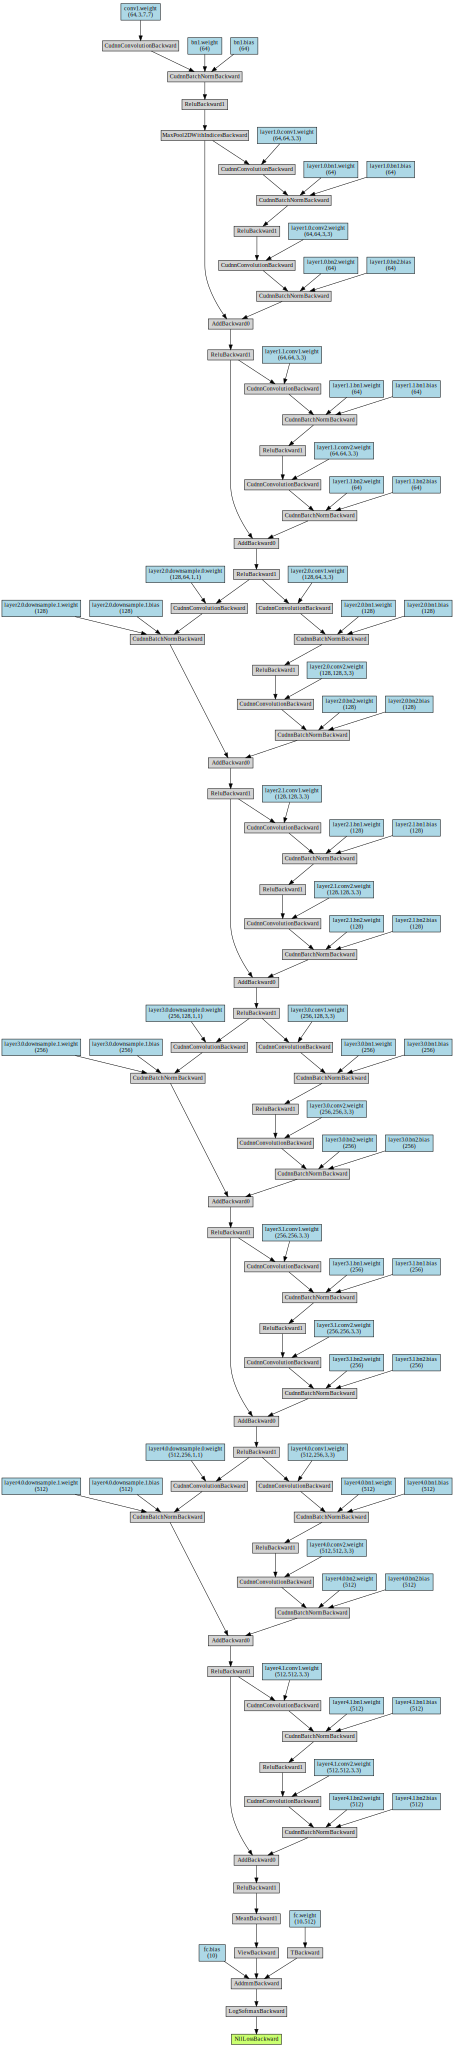

In [ ]:
# 損失関数のグラフ表示

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
# 確認
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# モデルのサマリー表示
net = net.to(device)
summary(net,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

## 11.8 学習と結果評価

### 最適化関数などの定義

In [ ]:
# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# historyファイル初期化する
history = np.zeros((0, 5))

### 学習

In [ ]:
# 学習

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.01116 acc: 0.80932 val_loss: 0.00492, val_acc: 0.91660



Epoch [2/5], loss: 0.00600 acc: 0.89818 val_loss: 0.00389, val_acc: 0.93330



Epoch [3/5], loss: 0.00475 acc: 0.91884 val_loss: 0.00358, val_acc: 0.93840



Epoch [4/5], loss: 0.00401 acc: 0.93020 val_loss: 0.00346, val_acc: 0.94100



Epoch [5/5], loss: 0.00343 acc: 0.94190 val_loss: 0.00326, val_acc: 0.94600


### 結果確認

初期状態: 損失関数: 0.00492 精度: 0.91660
最終状態: 損失関数: 0.00326 精度: 0.94600


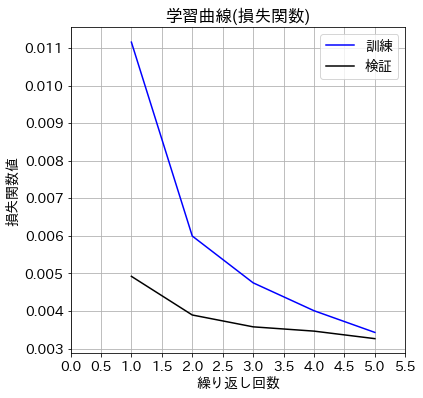

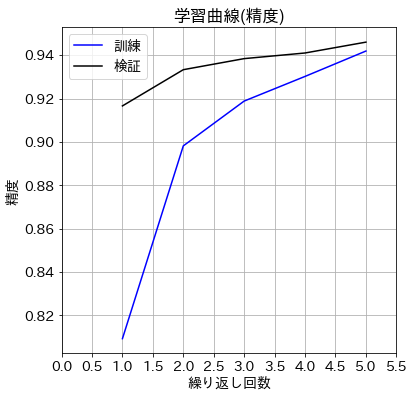

In [ ]:
# 結果サマリー

evaluate_history(history)

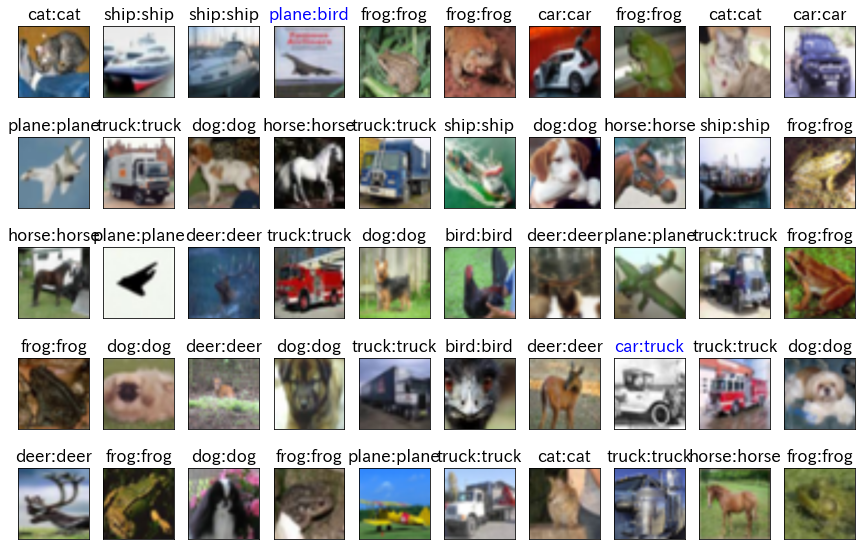

In [ ]:
# イメージと正解データ確認

show_predict_result(net, test_loader, classes, device)

## 11.9 vnn19-bnの利用

###  モデルの読み込み

In [ ]:
# 学習済みモデルの読み込み

from torchvision import models
net = models.vgg19_bn(pretrained = True)

###  モデル構造の確認

In [ ]:
# モデルの確認

print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

 最終レイヤー関数は``classifier[6]``であることがわかる

In [ ]:
# 最終レイヤー関数の確認

print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


### 最終レイヤー関数の付け替え

In [ ]:
# 最終レイヤー関数の付け替え
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

In [ ]:
# モデルのサマリー表示
net = net.to(device)
summary(net,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

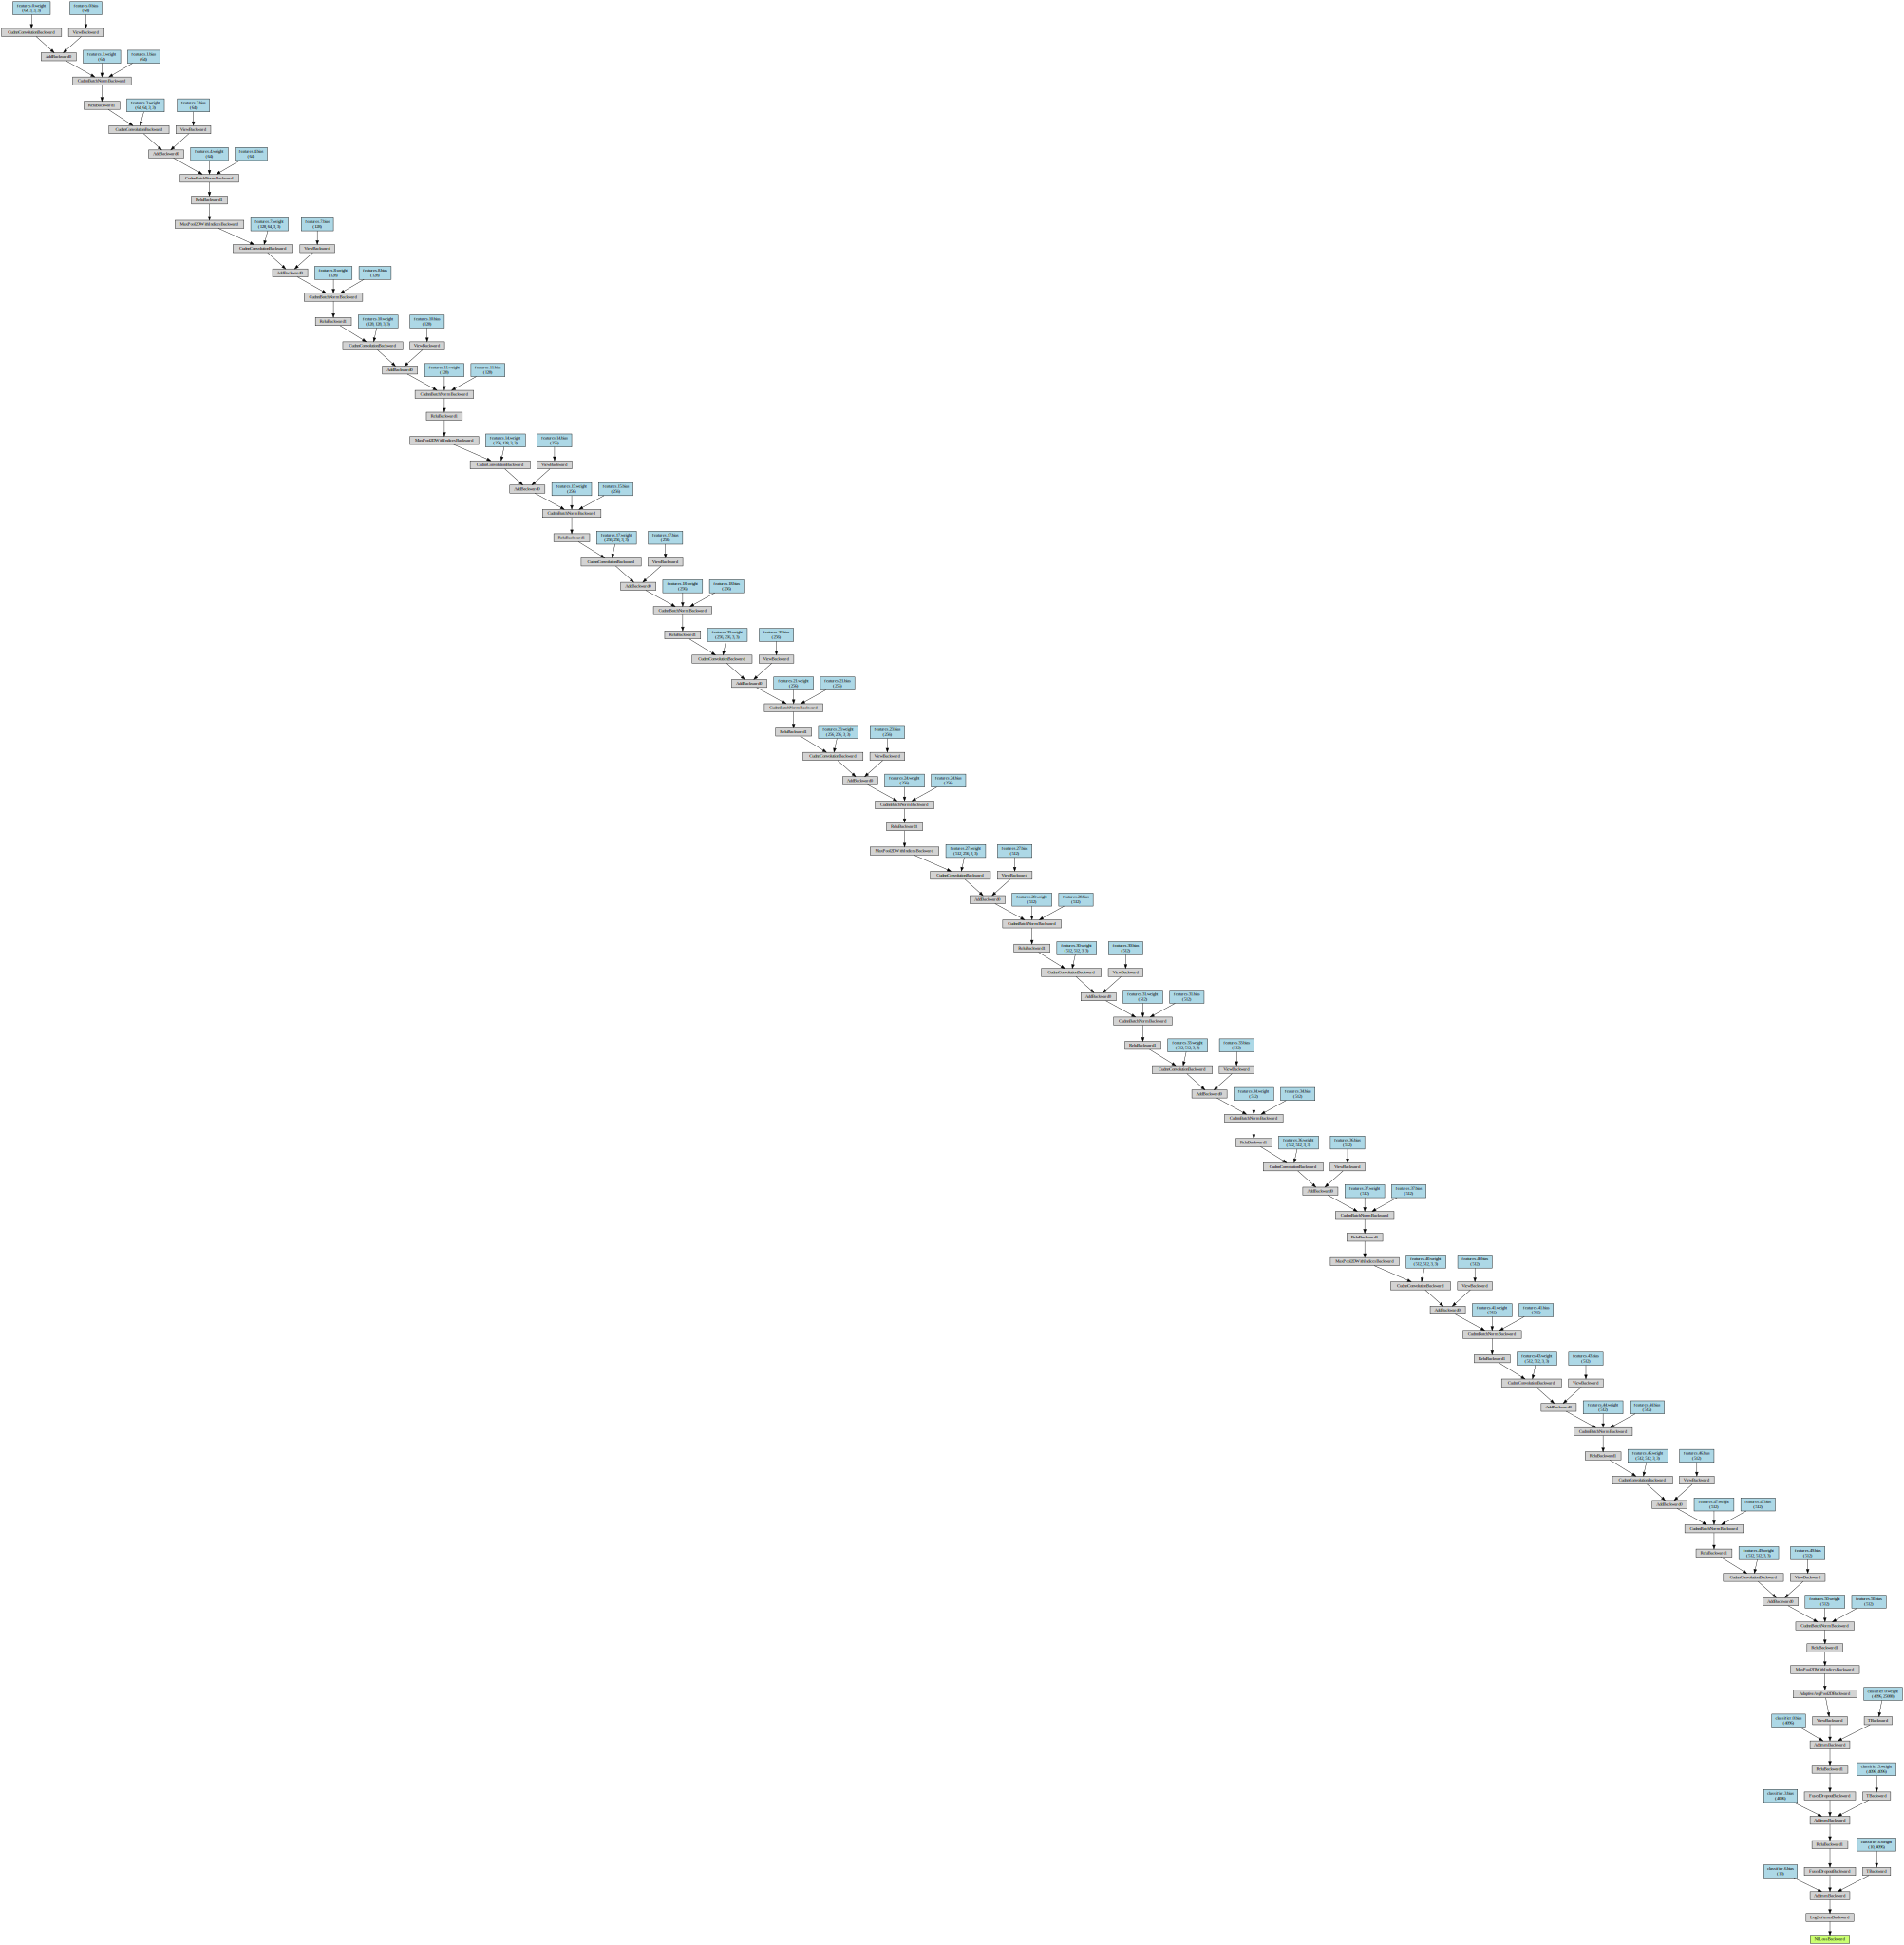

In [ ]:
# 損失関数のグラフ表示

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, params=dict(net.named_parameters()))

### 最適化関数などの定義

In [ ]:
# モデルをGPUに送付
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# historyの初期化
history = np.zeros((0, 5))

### 学習

In [ ]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.00911 acc: 0.84562 val_loss: 0.00341, val_acc: 0.94230



Epoch [2/5], loss: 0.00453 acc: 0.92364 val_loss: 0.00289, val_acc: 0.95100



Epoch [3/5], loss: 0.00343 acc: 0.94104 val_loss: 0.00280, val_acc: 0.95170



Epoch [4/5], loss: 0.00284 acc: 0.95168 val_loss: 0.00247, val_acc: 0.95860



Epoch [5/5], loss: 0.00249 acc: 0.95738 val_loss: 0.00233, val_acc: 0.96060


### 結果確認

初期状態: 損失関数: 0.00363 精度: 0.93910
最終状態: 損失関数: 0.00254 精度: 0.96080


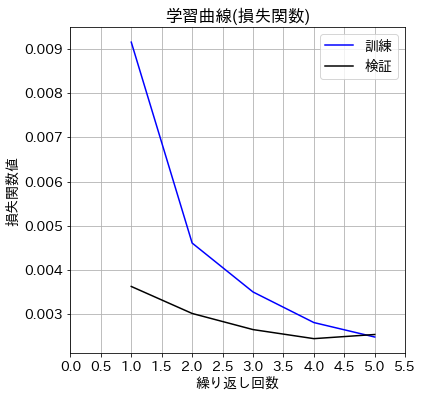

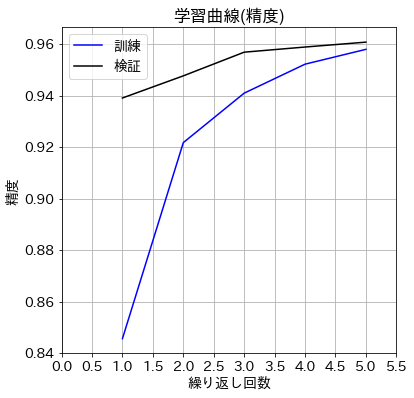

In [ ]:
# 結果サマリー

evaluate_history(history)

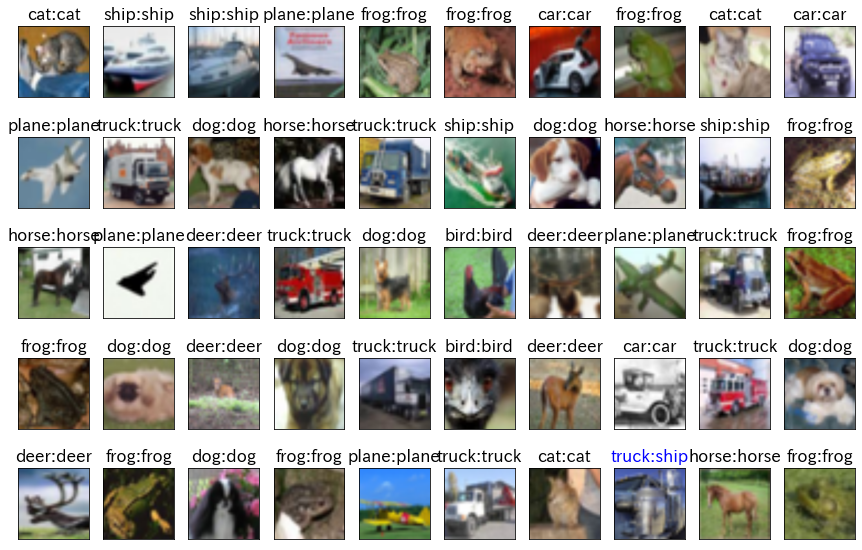

In [ ]:
# イメージと正解データ確認

show_predict_result(net, test_loader, classes, device)

## コラム CIFAR-10に転移学習を適用した場合


In [ ]:
# 転移学習バージョン

# 学習済みモデルの読み込み
net = models.resnet18(pretrained = True)

# すべてのパラメータで勾配計算をOFFにする
for param in net.parameters():
    param.requires_grad = False

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(net.fc.in_features, n_output)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ変更は最終レイヤー関数に限定
optimizer = optim.SGD(net.fc.parameters(), lr=lr, momentum=0.9)

# historyファイル初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.02161 acc: 0.63954 val_loss: 0.01408, val_acc: 0.76670



Epoch [2/5], loss: 0.01761 acc: 0.69498 val_loss: 0.01338, val_acc: 0.77750



Epoch [3/5], loss: 0.01691 acc: 0.70894 val_loss: 0.01291, val_acc: 0.78510



Epoch [4/5], loss: 0.01673 acc: 0.71364 val_loss: 0.01249, val_acc: 0.78860



Epoch [5/5], loss: 0.01646 acc: 0.71734 val_loss: 0.01256, val_acc: 0.78670
